In [1]:
from matplotlib.pylab import plt

import numpy as np

def read_output(fname):
    vals = np.zeros([96,6])
    with open(fname) as f:
        i = 0
        for l in f.readlines():
            if '****' in l:
                v = l.split()
                vals[i] =[float(x) for x in (v[6],v[11],v[17],v[20],v[23],v[27])]
                i += 1
    return vals

# Getting OpenMP to work on Marconi 100

You can find below the time taken by a 2000x2000 DGEMM on the login node of Marconi 100

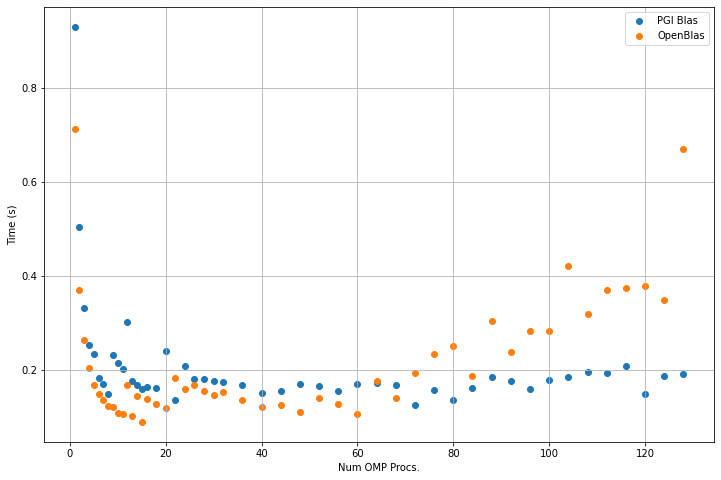

In [2]:
vals = read_output('on_login')
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax.scatter(vals[:48,0],vals[:48,5], label='PGI Blas')
ax.scatter(vals[48:,0],vals[48:,5], label='OpenBlas')
ax.set_xlabel('Num OMP Procs.')
ax.set_ylabel('Time (s)')
ax.legend()
ax.grid()
plt.show()

## On compute node 1

Below are the results on the compute node with the following script


     #!/bin/bash
     #SBATCH --nodes=1               # number of nodes
     #SBATCH --ntasks-per-node=4     # number of tasks per node
     #SBATCH --ntasks-per-socket=2   # number of tasks per socket
     #SBATCH --cpus-per-task=32      # number of HW threads per task (equal to OMP_NUM_THREADS*4)
     #SBATCH --mem=230000MB
     #SBATCH --time 01:00:00         # format: HH:MM:SS
     #SBATCH -A cin_preM100 
     #SBATCH -p system
     
     cat run_me.sh
     
     module load profile/global pgi/19.10--binary gnu/8.4.0 fftw/3.3.8--gnu--8.4.0 cuda/10.1
     
     
     # PGI + Internal Blas
     mpif90 -mp test.f90 -lblas -o pgi_blas.x
     
     for i in {1..16} {18..32..2} {36..128..4}
     do
         export OMP_NUM_THREADS=$i
         mpirun -np 1  ./pgi_blas.x 2000 2000  | tr '\n' '\t'
         echo
     done 
     
     echo '=== OpenBLAS ==='
     mpif90 -mp test.f90 -o pgi_openblas.x -L./openblas/lib -lopenblas
     export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:`pwd`/openblas/lib
     
     for i in {1..16} {18..32..2} {36..128..4}
     do
         export OMP_NUM_THREADS=$i
         mpirun -np 1 ./pgi_openblas.x 2000 2000  | tr '\n' '\t'
         echo
     done 

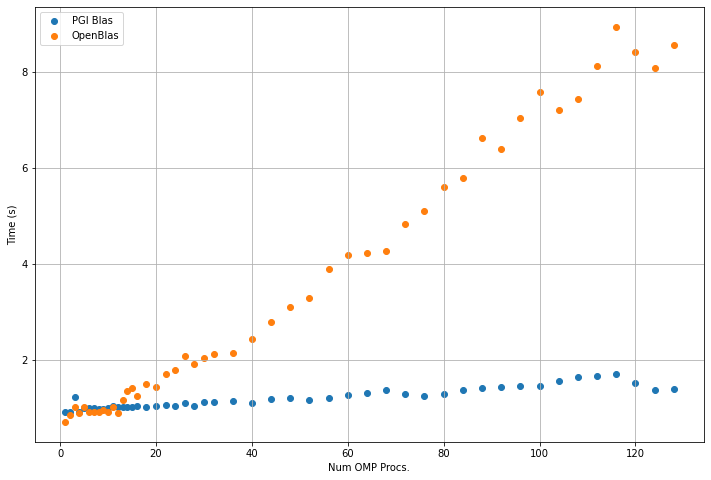

In [3]:
vals = read_output('slurm-1318.out')
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax.scatter(vals[:48,0],vals[:48,5], label='PGI Blas')
ax.scatter(vals[48:,0],vals[48:,5], label='OpenBlas')
ax.set_xlabel('Num OMP Procs.')
ax.set_ylabel('Time (s)')
ax.legend()
ax.grid()
plt.show()

## On compute node 2

Below are the results on the compute node with the following script, notice **--bind-to none** added to mpirun command.


    #!/bin/bash
    #SBATCH --nodes=1               # number of     #!/bin/bash
    #SBATCH --nodes=1               # number of nodes
    #SBATCH --ntasks-per-node=4     # number of tasks per node
    #SBATCH --ntasks-per-socket=2   # number of tasks per socket
    #SBATCH --cpus-per-task=32      # number of HW threads per task (equal to OMP_NUM_THREADS*4)
    #SBATCH --mem=230000MB
    #SBATCH --time 01:00:00         # format: HH:MM:SS
    #SBATCH -A cin_preM100 
    #SBATCH -p system
    
    cat run_me.sh
    
    module load profile/global pgi/19.10--binary gnu/8.4.0 fftw/3.3.8--gnu--8.4.0 cuda/10.1
    
    
    # PGI + Internal Blas
    mpif90 -mp test.f90 -lblas -o pgi_blas.x
    
    for i in {1..16} {18..32..2} {36..128..4}
    do
        export OMP_NUM_THREADS=$i
        mpirun -np 1 --bind-to none  ./pgi_blas.x 2000 2000  | tr '\n' '\t'
        echo
    done 
    
    echo '=== OpenBLAS ==='
    mpif90 -mp test.f90 -o pgi_openblas.x -L./openblas/lib -lopenblas
    export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:`pwd`/openblas/lib
    
    for i in {1..16} {18..32..2} {36..128..4}
    do
        export OMP_NUM_THREADS=$i
        mpirun -np 1 --bind-to none ./pgi_openblas.x 2000 2000  | tr '\n' '\t'
        echo
    done nodes
    #SBATCH --ntasks-per-node=4     # number of tasks per node
    #SBATCH --ntasks-per-socket=2   # number of tasks per socket
    #SBATCH --cpus-per-task=32      # number of HW threads per task (equal to OMP_NUM_THREADS*4)
    #SBATCH --mem=230000MB
    #SBATCH --time 01:00:00         # format: HH:MM:SS
    #SBATCH -A cin_preM100 
    #SBATCH -p system
    
    cat run_me.sh
    
    module load profile/global pgi/19.10--binary gnu/8.4.0 fftw/3.3.8--gnu--8.4.0 cuda/10.1
    
    
    # PGI + Internal Blas
    mpif90 -mp test.f90 -lblas -o pgi_blas.x
    
    for i in {1..16} {18..32..2} {36..128..4}
    do
        export OMP_NUM_THREADS=$i
        mpirun -np 1 --bind-to none  ./pgi_blas.x 2000 2000  | tr '\n' '\t'
        echo
    done 
    
    echo '=== OpenBLAS ==='
    mpif90 -mp test.f90 -o pgi_openblas.x -L./openblas/lib -lopenblas
    export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:`pwd`/openblas/lib
    
    for i in {1..16} {18..32..2} {36..128..4}
    do
        export OMP_NUM_THREADS=$i
        mpirun -np 1 --bind-to none ./pgi_openblas.x 2000 2000  | tr '\n' '\t'
        echo
    done 

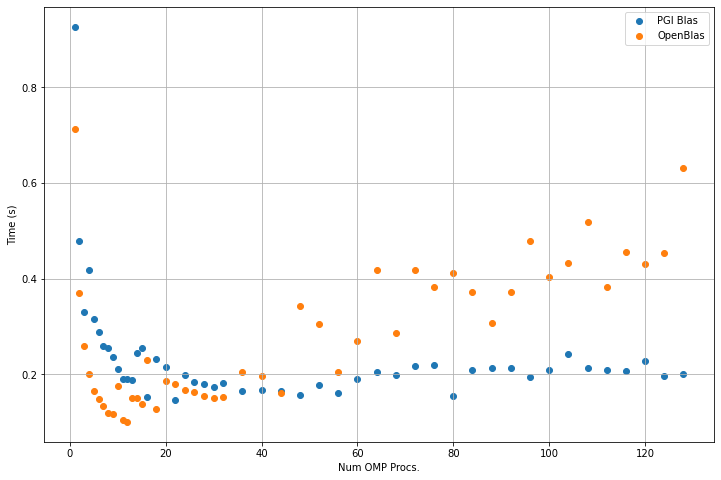

In [4]:
vals = read_output('slurm-1326.out')
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax.scatter(vals[:48,0],vals[:48,5], label='PGI Blas')
ax.scatter(vals[48:,0],vals[48:,5], label='OpenBlas')
ax.set_xlabel('Num OMP Procs.')
ax.set_ylabel('Time (s)')
ax.legend()
ax.grid()
plt.show()

## On compute node 3

Below are the results on the compute node with the following script, notice **--bind-to none** added to mpirun command but this time I run multiple MPI per node: there are 4 MPI processes per node leaving 8 physical cores per MPI process, more than enough to go below 0.2 s for a dgemm. On the other hand the DGEMM takes about twice as much.


    #!/bin/bash
    #SBATCH --nodes=2               # number of nodes
    #SBATCH --ntasks-per-node=4     # number of tasks per node
    #SBATCH --ntasks-per-socket=2   # number of tasks per socket
    #SBATCH --cpus-per-task=32      # number of HW threads per task (equal to OMP_NUM_THREADS*4)
    #SBATCH --mem=230000MB
    #SBATCH --time 01:00:00         # format: HH:MM:SS
    #SBATCH -A cin_preM100 
    #SBATCH -p system
    
    cat run_me.sh
    
    module load profile/global pgi/19.10--binary gnu/8.4.0 fftw/3.3.8--gnu--8.4.0 cuda/10.1
    
    
    # PGI + Internal Blas
    mpif90 -mp test.f90 -lblas -o pgi_blas.x
    
    for i in {1..16} {18..32..2} {36..128..4}
    do
        export OMP_NUM_THREADS=$i
        mpirun --bind-to none  ./pgi_blas.x 2000 2000  | tr '\n' '\t'
        echo
    done 
    
    echo '=== OpenBLAS ==='
    mpif90 -mp test.f90 -o pgi_openblas.x -L./openblas/lib -lopenblas
    export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:`pwd`/openblas/lib
    
    for i in {1..16} {18..32..2} {36..128..4}
    do
        export OMP_NUM_THREADS=$i
        mpirun --bind-to none ./pgi_openblas.x 2000 2000  | tr '\n' '\t'
        echo
    done 

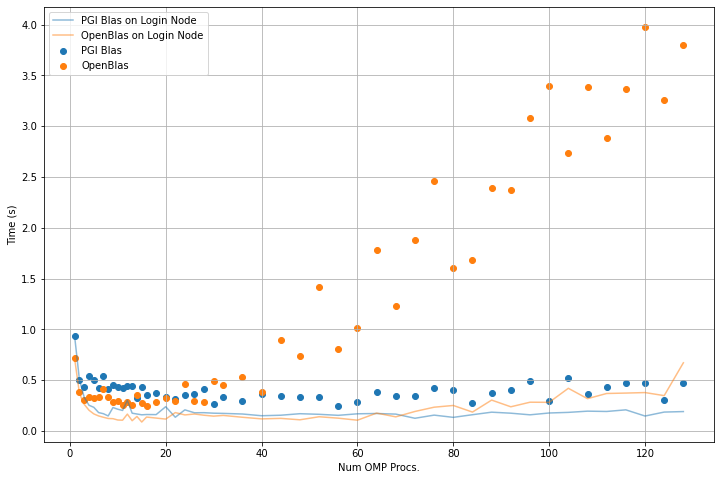

In [5]:
vals = read_output('slurm-1327.out')
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax.scatter(vals[:48,0],vals[:48,5], label='PGI Blas')
ax.scatter(vals[48:,0],vals[48:,5], label='OpenBlas')

vals = read_output('on_login')
ax.plot(vals[:48,0],vals[:48,5], alpha=0.5, label='PGI Blas on Login Node')
ax.plot(vals[48:,0],vals[48:,5], alpha=0.5, label='OpenBlas on Login Node')

ax.set_xlabel('Num OMP Procs.')
ax.set_ylabel('Time (s)')

ax.legend()
ax.grid()
plt.show()